In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse

# Functions for creating features, modelling, plotting

In [16]:
def prepare_data(train_val_test_dates=[None, None, None],
                 extra_features=None,
                 only_normal_shops=False,
                 only_normal_items=False):
    """
    Prepares the data in "train_clean.csv" for xgboost, with options for feature engineering and other manipulation.

    Args:
        train_val_test_dates: 'YYYY-MM-DD' format, specify train start date, val start date, test start date.
        extra_features=None: if True, item_category and an assortment of time-based features are added
        only_normal_shops=False: some shops are not present in "test.csv" and tend to have unusual distributions. if True, exclude these.
        only_normal_items=False: some items are not present in "test.csv". if True, exclude these.

    Returns:
        dtrain, dvalidation, dtest, train, validation, test, df
    """
    def only_normal(df, shops=False, items=False):
        """
        Returns df with only shops, items found in "test.csv" depending on if shops, items = True is set (defaults: False). mutates df.
        """
        normal = pd.read_csv('test.csv')

        # if enabled, only items and/or shops in 'test.csv' are retained in self.df
        if shops:
            normal_shops = normal['shop_id'].unique()
            df = df[df['shop_id'].isin(normal_shops)]
        if items:
            normal_items = normal['item_id'].unique()
            df = df[df['item_id'].isin(normal_items)]
        return df

    def add_features(df):
        """
        Add item categories to df and assorted date features. Mutates df.

        Returns: df
        """
        items = pd.read_csv("items.csv")
        # get items csv and use id and categories columns as key to add item categories to dataframe
        df['item_category_id'] = df['item_id'].map(items.set_index('item_id')['item_category_id'])

        # add some time features, add the dates as a column to do this, remove date column at the end
        df['date'] = df.index
        df['dayofweek'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day

        df.drop(columns='date', inplace=True)
        return df

    def train_val_test_split(df, train_val_test_dates):
        """
        Returns train, val, test split of df, as dataframes including labels, according to date splits. Does not mutate df.

        Format: 'YYYY-MM-DD'
        """
        train_start_date, val_start_date, test_start_date = train_val_test_dates[0], train_val_test_dates[1], train_val_test_dates[2]

        train = df[(train_start_date <= df.index) & (df.index < val_start_date)].copy()
        validation = df[(val_start_date <= df.index) & (df.index < test_start_date)].copy()
        test = df[test_start_date <= df.index].copy()

        return train, validation, test

    def make_dmatrix(df):
        """
        Convert pandas dataframe to DMatrix for xgboost, splitting off labels and including in dmatrix as need. Does not mutate df.
        """
        X = df.copy()
        y = X.pop('item_cnt_day')
        dmatrix = xgb.DMatrix(X, label=y)
        return dmatrix

    # import and use dates as index, sort by date
    df = pd.read_csv("train_clean.csv", index_col=[0], parse_dates=[0], dayfirst=True)
    df = df.sort_index()

    # if True, use only shops and/or items found in "test.csv"
    if only_normal_shops:
        df = only_normal(df, shops=True)
    if only_normal_items:
        df = only_normal(df, items=True)

    # if True, add item category and various time features
    if extra_features:
        df = add_features(df)

    train, validation, test = train_val_test_split(df, train_val_test_dates)

    # dmatrices for xgboost
    dtrain, dvalidation, dtest = make_dmatrix(train), make_dmatrix(validation), make_dmatrix(test)

    return dtrain, dvalidation, dtest, train, validation, test, df


In [18]:
# make model
def make_model(num_trees=100,
               train_val_test_dates=[None, None, None],
               extra_features=None,
               only_normal_shops=False,
               only_normal_items=False):
    """
    Make model using parameters for data pipeline.
    """

    dtrain, dvalidation, dtest, _, _, _, _ = prepare_data(train_val_test_dates=train_val_test_dates,
                                            extra_features=extra_features,
                                            only_normal_shops=only_normal_shops,
                                            only_normal_items=only_normal_items)

    params = {}
    params['eval_metric'] = ['mape', 'mae', 'rmse']
    params['nthread'] = 4
    params['eta'] = .3 # learning rate, default = 0.3
    params['max_depth'] = 6 # default = 6

    # gpu (needs CUDA compute >= 3.5)
    # params['gpu_id'] = 0
    # params['tree_method'] = 'gpu_hist'

    # track performance on this data
    evallist = [(dtrain, 'train'), (dvalidation, 'eval')] # last metric is used for early stopping

    num_boost_round = num_trees # how many trees, default = 10
    early_stopping_rounds = 50

    model = xgb.train(params=params,
                    dtrain=dtrain,
                    num_boost_round=num_boost_round,
                    evals=evallist
                    # uncomment for early stopping
                    # early_stopping_rounds=early_stopping_rounds
                      )

    return model

In [19]:
def plot_predictions(model, dmatrix, data):
    """
    Plot predictions and true sum of item_cnt values for each date.
    """
    # use best iteration
    predictions = model.predict(dmatrix) #, ntree_limit=model.best_iteration)

    compare = pd.DataFrame(data=predictions, index=data.index, columns=['Predicted Values'])
    compare['True Values'] = data['item_cnt_day']

    # calculate totals for each date
    return compare.groupby('date').sum().plot(figsize=(10, 3))


In [20]:
def plot_predictions_scatter(model, dmatrix, data):
    """
    Scatter plot of predictions and true sum of item_cnt values for each date.
    """
    # use best iteration
    predictions = model.predict(dmatrix) #, ntree_limit=model.best_iteration)

    compare = pd.DataFrame(data=predictions, index=data.index, columns=['Predicted Values'])
    compare['True Values'] = data['item_cnt_day']

    # calculate totals for each date
    return compare.plot.scatter(x='True Values', y='Predicted Values', c='DarkBlue')


In [21]:
def summarize_model(num_trees=10,
                    train_val_test_dates=[None, None, None],
                    extra_features=False,
                    only_normal_shops=False,
                    only_normal_items=False,
                    save_figs=False):

    # train model
    model = make_model(num_trees=num_trees,
                    train_val_test_dates=train_val_test_dates,
                    extra_features=extra_features,
                    only_normal_shops=only_normal_shops,
                    only_normal_items=only_normal_items)

    # for plotting
    _, dvalidation, dtest, train, validation, test, _ = prepare_data(train_val_test_dates=train_val_test_dates,
                                                                    extra_features=extra_features,
                                                                    only_normal_shops=only_normal_shops,
                                                                    only_normal_items=only_normal_items)
    # feature importance
    if save_figs:
        ax = xgb.plot_importance(model)
        print(ax)
        ax.figure.tight_layout()
        ax.figure.savefig(save_figs+'_feature_importance.png')
    else:
        print(xgb.plot_importance(model))

    # validation plots
    if save_figs:
        ax = plot_predictions(model, dvalidation, validation)
        print(ax)
        ax.figure.tight_layout()
        ax.figure.savefig(save_figs+'_validation.png')
    else:
        print(plot_predictions(model, dvalidation, validation))

    # test plots
    if save_figs:
        ax = plot_predictions(model, dtest, test)
        print(ax)
        ax.figure.tight_layout()
        ax.figure.savefig(save_figs+'_test.png')
    else:
        print(plot_predictions(model, dtest, test))

    # validation scatter plot
    if save_figs:
        ax = plot_predictions_scatter(model, dvalidation, validation)
        print(ax)
        ax.figure.tight_layout()
        ax.figure.savefig(save_figs+'_validation_scatter.png')
    else:
        print(plot_predictions.scatter(model, dvalidation, validation))

    # test scatter plot
    if save_figs:
        ax = plot_predictions_scatter(model, dtest, test)
        print(ax)
        ax.figure.tight_layout()
        ax.figure.savefig(save_figs+'_test_scatter.png')
    else:
        print(plot_predictions_scatter(model, dtest, test))


    # calculate and print test rmse
    test_pred = model.predict(dtest)
    test_true = test['item_cnt_day'].values

    print("Test RMSE is: ", mse(test_true, test_pred, squared=False))


# Testing several models

[0]	train-mape:0.34255	train-mae:0.53045	train-rmse:2.10190	eval-mape:0.35244	eval-mae:0.73352	eval-rmse:6.16046


[1]	train-mape:0.21542	train-mae:0.38804	train-rmse:2.00562	eval-mape:0.22844	eval-mae:0.59223	eval-rmse:6.13975


[2]	train-mape:0.14449	train-mae:0.30740	train-rmse:1.95522	eval-mape:0.15876	eval-mae:0.51231	eval-rmse:6.12840


[3]	train-mape:0.12398	train-mae:0.28108	train-rmse:1.93404	eval-mape:0.13191	eval-mae:0.48056	eval-rmse:6.12320


[4]	train-mape:0.13323	train-mae:0.28584	train-rmse:1.91555	eval-mape:0.13832	eval-mae:0.48254	eval-rmse:6.11833


[5]	train-mape:0.14882	train-mae:0.29842	train-rmse:1.89745	eval-mape:0.15834	eval-mae:0.49837	eval-rmse:6.11219


[6]	train-mape:0.16604	train-mae:0.31258	train-rmse:1.88046	eval-mape:0.17547	eval-mae:0.50982	eval-rmse:6.10132


[7]	train-mape:0.17969	train-mae:0.32465	train-rmse:1.87220	eval-mape:0.17164	eval-mae:0.50289	eval-rmse:6.09198


[8]	train-mape:0.18891	train-mae:0.33233	train-rmse:1.85198	eval-mape:0.18063	eval-mae:0.51051	eval-rmse:6.09362


[9]	train-mape:0.19499	train-mae:0.33765	train-rmse:1.84694	eval-mape:0.18503	eval-mae:0.51251	eval-rmse:6.08975


[10]	train-mape:0.19928	train-mae:0.34109	train-rmse:1.84153	eval-mape:0.19134	eval-mae:0.51748	eval-rmse:6.08747


[11]	train-mape:0.20248	train-mae:0.34416	train-rmse:1.83778	eval-mape:0.18357	eval-mae:0.50999	eval-rmse:6.08735


[12]	train-mape:0.20401	train-mae:0.34503	train-rmse:1.83453	eval-mape:0.18471	eval-mae:0.51094	eval-rmse:6.08709


[13]	train-mape:0.20505	train-mae:0.34551	train-rmse:1.82987	eval-mape:0.18663	eval-mae:0.51165	eval-rmse:6.08412


[14]	train-mape:0.20576	train-mae:0.34580	train-rmse:1.82638	eval-mape:0.18017	eval-mae:0.50471	eval-rmse:6.08327


[15]	train-mape:0.20610	train-mae:0.34574	train-rmse:1.82384	eval-mape:0.18099	eval-mae:0.50427	eval-rmse:6.08263


[16]	train-mape:0.20608	train-mae:0.34535	train-rmse:1.81345	eval-mape:0.18137	eval-mae:0.50445	eval-rmse:6.08173


[17]	train-mape:0.20499	train-mae:0.34363	train-rmse:1.80966	eval-mape:0.17926	eval-mae:0.50234	eval-rmse:6.08119


[18]	train-mape:0.20484	train-mae:0.34317	train-rmse:1.80758	eval-mape:0.17885	eval-mae:0.50253	eval-rmse:6.08223


[19]	train-mape:0.20434	train-mae:0.34221	train-rmse:1.80402	eval-mape:0.17836	eval-mae:0.50230	eval-rmse:6.08256


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


AxesSubplot(0.125,0.125;0.775x0.755)
Test RMSE is:  2.419216650990203


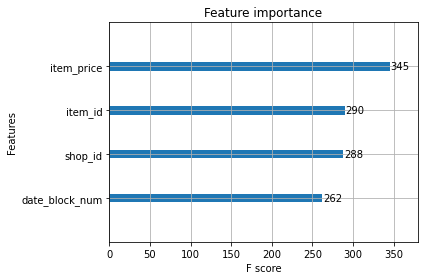

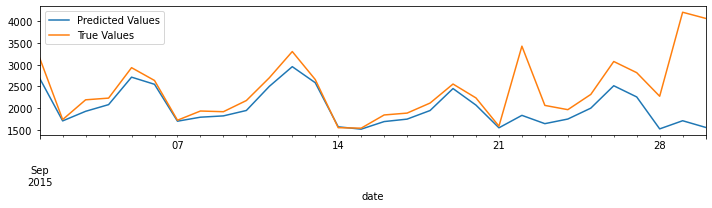

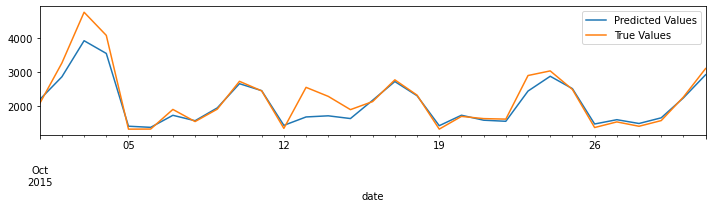

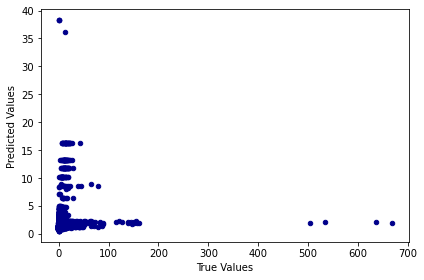

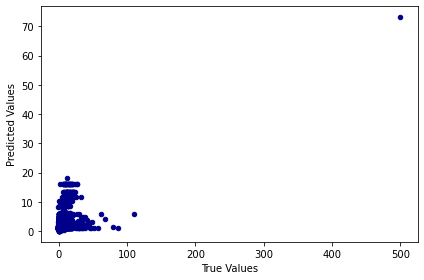

In [22]:
# baseline model
#
# results:
#
# val rmse always much higher than train, overfitting/model not very predictive
# decent looking summarising graphs for validation and test


# feature engineering parameters
# use all data, last month for test, 2nd last month for validation
train_val_test_dates = ['2013-01-01', '2015-09-01', '2015-10-01']
extra_features = False
only_normal_shops = False
only_normal_items = False

num_trees = 20

save_figs = 'baseline'

summarize_model(num_trees=num_trees,
                train_val_test_dates=train_val_test_dates,
                extra_features=extra_features,
                only_normal_shops=only_normal_shops,
                only_normal_items=only_normal_items,
                save_figs=save_figs)


[0]	train-mape:0.34370	train-mae:0.59587	train-rmse:2.57769	eval-mape:0.34683	eval-mae:0.56399	eval-rmse:1.68611


[1]	train-mape:0.22977	train-mae:0.45482	train-rmse:2.41455	eval-mape:0.22875	eval-mae:0.42576	eval-rmse:1.59932


[2]	train-mape:0.17690	train-mae:0.38584	train-rmse:2.33025	eval-mape:0.17836	eval-mae:0.36566	eval-rmse:1.56398


[3]	train-mape:0.16137	train-mae:0.35768	train-rmse:2.27990	eval-mape:0.15939	eval-mae:0.33909	eval-rmse:1.54036


[4]	train-mape:0.16817	train-mae:0.35807	train-rmse:2.22498	eval-mape:0.15525	eval-mae:0.33199	eval-rmse:1.53593


[5]	train-mape:0.17947	train-mae:0.36456	train-rmse:2.20092	eval-mape:0.16260	eval-mae:0.33676	eval-rmse:1.53092


[6]	train-mape:0.19060	train-mae:0.37264	train-rmse:2.17861	eval-mape:0.17047	eval-mae:0.34283	eval-rmse:1.52761


[7]	train-mape:0.20131	train-mae:0.37870	train-rmse:2.13060	eval-mape:0.17436	eval-mae:0.34570	eval-rmse:1.52355


[8]	train-mape:0.21013	train-mae:0.38482	train-rmse:2.12046	eval-mape:0.18429	eval-mae:0.35399	eval-rmse:1.51916


[9]	train-mape:0.21698	train-mae:0.39061	train-rmse:2.09706	eval-mape:0.19530	eval-mae:0.36392	eval-rmse:1.51755


[10]	train-mape:0.22198	train-mae:0.39498	train-rmse:2.08032	eval-mape:0.20108	eval-mae:0.36924	eval-rmse:1.51685


[11]	train-mape:0.22458	train-mae:0.39661	train-rmse:2.07361	eval-mape:0.20270	eval-mae:0.36990	eval-rmse:1.51638


[12]	train-mape:0.22700	train-mae:0.39865	train-rmse:2.06160	eval-mape:0.20548	eval-mae:0.37267	eval-rmse:1.51693


[13]	train-mape:0.22815	train-mae:0.39917	train-rmse:2.05534	eval-mape:0.20904	eval-mae:0.37542	eval-rmse:1.51597


[14]	train-mape:0.22772	train-mae:0.39745	train-rmse:2.01772	eval-mape:0.20783	eval-mae:0.37505	eval-rmse:1.52089


[15]	train-mape:0.22803	train-mae:0.39682	train-rmse:1.99529	eval-mape:0.21160	eval-mae:0.37847	eval-rmse:1.52695


[16]	train-mape:0.22784	train-mae:0.39599	train-rmse:1.98409	eval-mape:0.21047	eval-mae:0.37808	eval-rmse:1.52947


[17]	train-mape:0.22814	train-mae:0.39592	train-rmse:1.97488	eval-mape:0.20998	eval-mae:0.37774	eval-rmse:1.52759


[18]	train-mape:0.22744	train-mae:0.39456	train-rmse:1.95968	eval-mape:0.21037	eval-mae:0.37808	eval-rmse:1.52811


[19]	train-mape:0.22759	train-mae:0.39402	train-rmse:1.92920	eval-mape:0.20711	eval-mae:0.37482	eval-rmse:1.52681


[20]	train-mape:0.22707	train-mae:0.39272	train-rmse:1.91873	eval-mape:0.20606	eval-mae:0.37380	eval-rmse:1.52279


[21]	train-mape:0.22606	train-mae:0.39080	train-rmse:1.91229	eval-mape:0.20596	eval-mae:0.37386	eval-rmse:1.52415


[22]	train-mape:0.22536	train-mae:0.38930	train-rmse:1.89241	eval-mape:0.20418	eval-mae:0.37143	eval-rmse:1.51923


[23]	train-mape:0.22517	train-mae:0.38867	train-rmse:1.88730	eval-mape:0.20439	eval-mae:0.37161	eval-rmse:1.51917


[24]	train-mape:0.22507	train-mae:0.38840	train-rmse:1.88409	eval-mape:0.20541	eval-mae:0.37204	eval-rmse:1.52062


[25]	train-mape:0.22460	train-mae:0.38751	train-rmse:1.87522	eval-mape:0.21193	eval-mae:0.37703	eval-rmse:1.51736


[26]	train-mape:0.22448	train-mae:0.38687	train-rmse:1.87298	eval-mape:0.21278	eval-mae:0.37770	eval-rmse:1.51697


[27]	train-mape:0.22450	train-mae:0.38664	train-rmse:1.86796	eval-mape:0.21312	eval-mae:0.37789	eval-rmse:1.51653


[28]	train-mape:0.22431	train-mae:0.38606	train-rmse:1.85618	eval-mape:0.21327	eval-mae:0.37825	eval-rmse:1.51686


[29]	train-mape:0.22419	train-mae:0.38571	train-rmse:1.85290	eval-mape:0.21058	eval-mae:0.37560	eval-rmse:1.51425


[30]	train-mape:0.22335	train-mae:0.38398	train-rmse:1.83412	eval-mape:0.20833	eval-mae:0.37350	eval-rmse:1.51213


[31]	train-mape:0.22341	train-mae:0.38393	train-rmse:1.83123	eval-mape:0.20851	eval-mae:0.37366	eval-rmse:1.51207


[32]	train-mape:0.22383	train-mae:0.38422	train-rmse:1.82991	eval-mape:0.20864	eval-mae:0.37374	eval-rmse:1.51199


[33]	train-mape:0.22415	train-mae:0.38443	train-rmse:1.82811	eval-mape:0.20934	eval-mae:0.37444	eval-rmse:1.51197


[34]	train-mape:0.22362	train-mae:0.38316	train-rmse:1.81472	eval-mape:0.20842	eval-mae:0.37351	eval-rmse:1.51157


[35]	train-mape:0.22394	train-mae:0.38338	train-rmse:1.81237	eval-mape:0.20886	eval-mae:0.37384	eval-rmse:1.51101


[36]	train-mape:0.22352	train-mae:0.38260	train-rmse:1.80870	eval-mape:0.20879	eval-mae:0.37341	eval-rmse:1.51029


[37]	train-mape:0.22362	train-mae:0.38222	train-rmse:1.79850	eval-mape:0.20596	eval-mae:0.37078	eval-rmse:1.50918


[38]	train-mape:0.22337	train-mae:0.38177	train-rmse:1.79495	eval-mape:0.20628	eval-mae:0.37077	eval-rmse:1.50808


[39]	train-mape:0.22314	train-mae:0.38109	train-rmse:1.78876	eval-mape:0.20641	eval-mae:0.37090	eval-rmse:1.50804


[40]	train-mape:0.22299	train-mae:0.38080	train-rmse:1.78435	eval-mape:0.20645	eval-mae:0.37113	eval-rmse:1.51140


[41]	train-mape:0.22288	train-mae:0.38055	train-rmse:1.77732	eval-mape:0.21177	eval-mae:0.37610	eval-rmse:1.51095


[42]	train-mape:0.22287	train-mae:0.38038	train-rmse:1.77684	eval-mape:0.21244	eval-mae:0.37663	eval-rmse:1.51073


[43]	train-mape:0.22267	train-mae:0.37990	train-rmse:1.77516	eval-mape:0.21174	eval-mae:0.37550	eval-rmse:1.51115


[44]	train-mape:0.22266	train-mae:0.37964	train-rmse:1.77416	eval-mape:0.21206	eval-mae:0.37568	eval-rmse:1.51089


[45]	train-mape:0.22244	train-mae:0.37926	train-rmse:1.77103	eval-mape:0.20963	eval-mae:0.37431	eval-rmse:1.51603


[46]	train-mape:0.22223	train-mae:0.37855	train-rmse:1.74571	eval-mape:0.20948	eval-mae:0.37422	eval-rmse:1.51565


[47]	train-mape:0.22208	train-mae:0.37823	train-rmse:1.74494	eval-mape:0.20927	eval-mae:0.37401	eval-rmse:1.51561


[48]	train-mape:0.22195	train-mae:0.37780	train-rmse:1.73832	eval-mape:0.20932	eval-mae:0.37414	eval-rmse:1.51791


[49]	train-mape:0.22188	train-mae:0.37717	train-rmse:1.73426	eval-mape:0.20962	eval-mae:0.37440	eval-rmse:1.51786


[50]	train-mape:0.22205	train-mae:0.37710	train-rmse:1.72426	eval-mape:0.20879	eval-mae:0.37363	eval-rmse:1.51893


[51]	train-mape:0.22207	train-mae:0.37697	train-rmse:1.72351	eval-mape:0.20897	eval-mae:0.37380	eval-rmse:1.51886


[52]	train-mape:0.22201	train-mae:0.37684	train-rmse:1.72232	eval-mape:0.21540	eval-mae:0.38102	eval-rmse:1.56111


[53]	train-mape:0.22197	train-mae:0.37668	train-rmse:1.72070	eval-mape:0.21537	eval-mae:0.38085	eval-rmse:1.55872


[54]	train-mape:0.22201	train-mae:0.37628	train-rmse:1.70121	eval-mape:0.21487	eval-mae:0.38088	eval-rmse:1.56194


[55]	train-mape:0.22182	train-mae:0.37568	train-rmse:1.69446	eval-mape:0.21502	eval-mae:0.38103	eval-rmse:1.56195


[56]	train-mape:0.22211	train-mae:0.37573	train-rmse:1.68961	eval-mape:0.22427	eval-mae:0.38954	eval-rmse:1.56673


[57]	train-mape:0.22207	train-mae:0.37564	train-rmse:1.68841	eval-mape:0.22445	eval-mae:0.38969	eval-rmse:1.56669


[58]	train-mape:0.22184	train-mae:0.37524	train-rmse:1.68735	eval-mape:0.22615	eval-mae:0.39098	eval-rmse:1.56618


[59]	train-mape:0.22185	train-mae:0.37517	train-rmse:1.68704	eval-mape:0.22608	eval-mae:0.39091	eval-rmse:1.56622


[60]	train-mape:0.22171	train-mae:0.37474	train-rmse:1.67902	eval-mape:0.22663	eval-mae:0.39185	eval-rmse:1.57027


[61]	train-mape:0.22176	train-mae:0.37451	train-rmse:1.67291	eval-mape:0.22695	eval-mae:0.39213	eval-rmse:1.57237


[62]	train-mape:0.22153	train-mae:0.37406	train-rmse:1.67187	eval-mape:0.22723	eval-mae:0.39236	eval-rmse:1.57252


[63]	train-mape:0.22168	train-mae:0.37399	train-rmse:1.66224	eval-mape:0.22765	eval-mae:0.39275	eval-rmse:1.57044


[64]	train-mape:0.22174	train-mae:0.37397	train-rmse:1.66189	eval-mape:0.22838	eval-mae:0.39342	eval-rmse:1.57048


[65]	train-mape:0.22174	train-mae:0.37374	train-rmse:1.65752	eval-mape:0.22788	eval-mae:0.39302	eval-rmse:1.57009


[66]	train-mape:0.22135	train-mae:0.37304	train-rmse:1.65430	eval-mape:0.22830	eval-mae:0.39356	eval-rmse:1.57069


[67]	train-mape:0.22118	train-mae:0.37275	train-rmse:1.65156	eval-mape:0.22840	eval-mae:0.39356	eval-rmse:1.57071


[68]	train-mape:0.22123	train-mae:0.37263	train-rmse:1.64580	eval-mape:0.22814	eval-mae:0.39339	eval-rmse:1.57112


[69]	train-mape:0.22074	train-mae:0.37175	train-rmse:1.64249	eval-mape:0.22849	eval-mae:0.39376	eval-rmse:1.57188


[70]	train-mape:0.22097	train-mae:0.37185	train-rmse:1.63998	eval-mape:0.22918	eval-mae:0.39444	eval-rmse:1.57192


[71]	train-mape:0.22059	train-mae:0.37140	train-rmse:1.63527	eval-mape:0.22879	eval-mae:0.39410	eval-rmse:1.57216


[72]	train-mape:0.22052	train-mae:0.37123	train-rmse:1.63106	eval-mape:0.22835	eval-mae:0.39395	eval-rmse:1.57676


[73]	train-mape:0.22052	train-mae:0.37119	train-rmse:1.63083	eval-mape:0.22817	eval-mae:0.39374	eval-rmse:1.57654


[74]	train-mape:0.22019	train-mae:0.37058	train-rmse:1.62792	eval-mape:0.22971	eval-mae:0.39479	eval-rmse:1.57389


[75]	train-mape:0.22019	train-mae:0.37041	train-rmse:1.62130	eval-mape:0.22982	eval-mae:0.39487	eval-rmse:1.57392


[76]	train-mape:0.22016	train-mae:0.37031	train-rmse:1.62095	eval-mape:0.22973	eval-mae:0.39476	eval-rmse:1.57388


[77]	train-mape:0.22012	train-mae:0.37014	train-rmse:1.61910	eval-mape:0.23009	eval-mae:0.39507	eval-rmse:1.57384


[78]	train-mape:0.21996	train-mae:0.36976	train-rmse:1.61153	eval-mape:0.22947	eval-mae:0.39455	eval-rmse:1.57393


[79]	train-mape:0.21993	train-mae:0.36960	train-rmse:1.61052	eval-mape:0.22897	eval-mae:0.39399	eval-rmse:1.57242


[80]	train-mape:0.21966	train-mae:0.36893	train-rmse:1.60314	eval-mape:0.22982	eval-mae:0.39437	eval-rmse:1.57291


[81]	train-mape:0.21917	train-mae:0.36835	train-rmse:1.59614	eval-mape:0.22908	eval-mae:0.39372	eval-rmse:1.57305


[82]	train-mape:0.21911	train-mae:0.36810	train-rmse:1.59177	eval-mape:0.22999	eval-mae:0.39488	eval-rmse:1.57781


[83]	train-mape:0.21900	train-mae:0.36779	train-rmse:1.58741	eval-mape:0.23101	eval-mae:0.39571	eval-rmse:1.57737


[84]	train-mape:0.21901	train-mae:0.36758	train-rmse:1.58604	eval-mape:0.23122	eval-mae:0.39578	eval-rmse:1.57723


[85]	train-mape:0.21903	train-mae:0.36753	train-rmse:1.58388	eval-mape:0.23128	eval-mae:0.39584	eval-rmse:1.57723


[86]	train-mape:0.21873	train-mae:0.36700	train-rmse:1.58147	eval-mape:0.23067	eval-mae:0.39548	eval-rmse:1.57833


[87]	train-mape:0.21862	train-mae:0.36676	train-rmse:1.58073	eval-mape:0.23057	eval-mae:0.39543	eval-rmse:1.57845


[88]	train-mape:0.21860	train-mae:0.36671	train-rmse:1.58027	eval-mape:0.23050	eval-mae:0.39539	eval-rmse:1.57843


[89]	train-mape:0.21841	train-mae:0.36635	train-rmse:1.57961	eval-mape:0.23028	eval-mae:0.39520	eval-rmse:1.57862


[90]	train-mape:0.21823	train-mae:0.36611	train-rmse:1.57911	eval-mape:0.22933	eval-mae:0.39437	eval-rmse:1.57877


[91]	train-mape:0.21824	train-mae:0.36604	train-rmse:1.57703	eval-mape:0.22932	eval-mae:0.39437	eval-rmse:1.57801


[92]	train-mape:0.21784	train-mae:0.36547	train-rmse:1.57345	eval-mape:0.22916	eval-mae:0.39426	eval-rmse:1.57978


[93]	train-mape:0.21783	train-mae:0.36522	train-rmse:1.56865	eval-mape:0.22921	eval-mae:0.39445	eval-rmse:1.58106


[94]	train-mape:0.21800	train-mae:0.36532	train-rmse:1.56809	eval-mape:0.22938	eval-mae:0.39451	eval-rmse:1.58084


[95]	train-mape:0.21786	train-mae:0.36508	train-rmse:1.56727	eval-mape:0.22955	eval-mae:0.39468	eval-rmse:1.58072


[96]	train-mape:0.21773	train-mae:0.36483	train-rmse:1.56074	eval-mape:0.22936	eval-mae:0.39403	eval-rmse:1.56532


[97]	train-mape:0.21753	train-mae:0.36448	train-rmse:1.56050	eval-mape:0.22912	eval-mae:0.39369	eval-rmse:1.56527


AxesSubplot(0.125,0.125;0.775x0.755)


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


Test RMSE is:  2.315024722824876


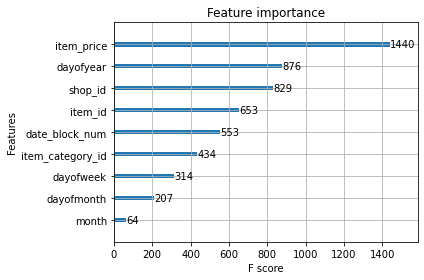

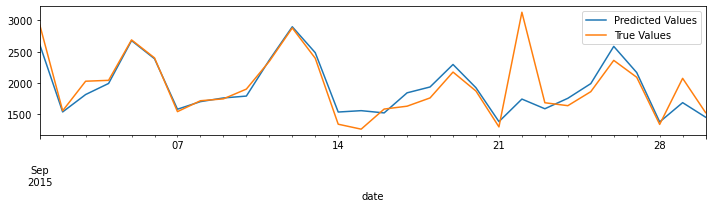

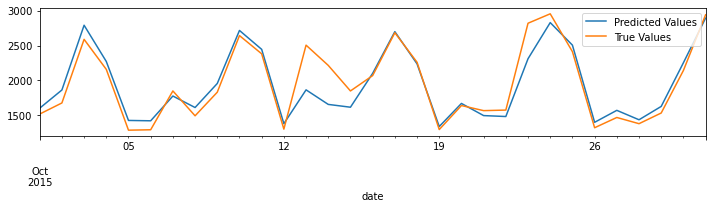

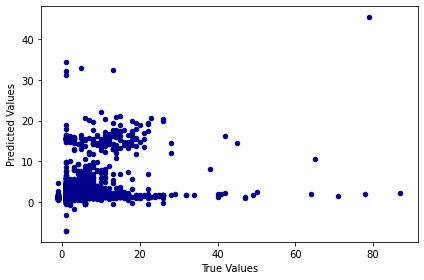

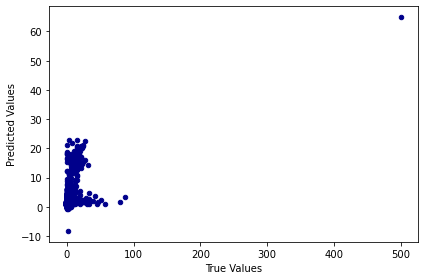

In [23]:
# add in feature engineering
#
# results:
#
# excellent improvement in rmse on validation
# not great rmse on test (not terrible).
# perhaps majority of test rmse error comes from a single day at the end of october
# googled russian holidays, but don't see anything to explain this
# otherwise, decent looking summarising graphs for validation and test


# feature engineering parameters
# use all data, last month for test, 2nd last month for validation
train_val_test_dates = ['2013-01-01', '2015-09-01', '2015-10-01']
extra_features = True
only_normal_shops = True
only_normal_items = True

num_trees = 98

save_figs = 'add_features'

summarize_model(num_trees=num_trees,
                train_val_test_dates=train_val_test_dates,
                extra_features=extra_features,
                only_normal_shops=only_normal_shops,
                only_normal_items=only_normal_items,
                save_figs=save_figs)


[0]	train-mape:0.35101	train-mae:0.54199	train-rmse:2.92057	eval-mape:0.35655	eval-mae:0.57762	eval-rmse:1.69105


[1]	train-mape:0.23938	train-mae:0.41030	train-rmse:2.68767	eval-mape:0.24354	eval-mae:0.44568	eval-rmse:1.60775


[2]	train-mape:0.17034	train-mae:0.33002	train-rmse:2.56106	eval-mape:0.18548	eval-mae:0.37612	eval-rmse:1.56251


[3]	train-mape:0.13752	train-mae:0.28890	train-rmse:2.47634	eval-mape:0.15040	eval-mae:0.33430	eval-rmse:1.54360


[4]	train-mape:0.12667	train-mae:0.27137	train-rmse:2.33169	eval-mape:0.13016	eval-mae:0.31026	eval-rmse:1.52804


[5]	train-mape:0.13553	train-mae:0.27679	train-rmse:2.25702	eval-mape:0.13207	eval-mae:0.30925	eval-rmse:1.51907


[6]	train-mape:0.14908	train-mae:0.28779	train-rmse:2.22463	eval-mape:0.14101	eval-mae:0.31561	eval-rmse:1.51078


[7]	train-mape:0.15910	train-mae:0.29501	train-rmse:2.17365	eval-mape:0.14513	eval-mae:0.31949	eval-rmse:1.51041


[8]	train-mape:0.16813	train-mae:0.30293	train-rmse:2.14940	eval-mape:0.14896	eval-mae:0.32297	eval-rmse:1.50521


[9]	train-mape:0.17535	train-mae:0.30915	train-rmse:2.13261	eval-mape:0.15617	eval-mae:0.32895	eval-rmse:1.49929


[10]	train-mape:0.18006	train-mae:0.31194	train-rmse:2.02880	eval-mape:0.16269	eval-mae:0.33450	eval-rmse:1.48547


[11]	train-mape:0.18396	train-mae:0.31509	train-rmse:2.01518	eval-mape:0.16543	eval-mae:0.33756	eval-rmse:1.48606


[12]	train-mape:0.18640	train-mae:0.31687	train-rmse:2.00820	eval-mape:0.16339	eval-mae:0.33536	eval-rmse:1.48399


[13]	train-mape:0.18574	train-mae:0.31441	train-rmse:1.94269	eval-mape:0.16324	eval-mae:0.33502	eval-rmse:1.48244


[14]	train-mape:0.18662	train-mae:0.31503	train-rmse:1.92538	eval-mape:0.16460	eval-mae:0.33613	eval-rmse:1.47435


[15]	train-mape:0.18712	train-mae:0.31474	train-rmse:1.90653	eval-mape:0.16450	eval-mae:0.33607	eval-rmse:1.47821


[16]	train-mape:0.18720	train-mae:0.31420	train-rmse:1.87548	eval-mape:0.16311	eval-mae:0.33470	eval-rmse:1.47858


[17]	train-mape:0.18797	train-mae:0.31421	train-rmse:1.86923	eval-mape:0.16851	eval-mae:0.33898	eval-rmse:1.47548


[18]	train-mape:0.18740	train-mae:0.31287	train-rmse:1.85732	eval-mape:0.16852	eval-mae:0.33859	eval-rmse:1.47110


[19]	train-mape:0.18532	train-mae:0.30947	train-rmse:1.78218	eval-mape:0.17047	eval-mae:0.34007	eval-rmse:1.46904


[20]	train-mape:0.18494	train-mae:0.30825	train-rmse:1.72775	eval-mape:0.17058	eval-mae:0.33964	eval-rmse:1.46780


[21]	train-mape:0.18503	train-mae:0.30763	train-rmse:1.71690	eval-mape:0.17179	eval-mae:0.34082	eval-rmse:1.46663


[22]	train-mape:0.18461	train-mae:0.30671	train-rmse:1.70876	eval-mape:0.17195	eval-mae:0.34095	eval-rmse:1.46662


[23]	train-mape:0.18342	train-mae:0.30500	train-rmse:1.65440	eval-mape:0.17131	eval-mae:0.34086	eval-rmse:1.47399


[24]	train-mape:0.18251	train-mae:0.30339	train-rmse:1.62587	eval-mape:0.17181	eval-mae:0.34096	eval-rmse:1.47110


[25]	train-mape:0.18261	train-mae:0.30327	train-rmse:1.61998	eval-mape:0.17229	eval-mae:0.34148	eval-rmse:1.47115


[26]	train-mape:0.18200	train-mae:0.30202	train-rmse:1.61059	eval-mape:0.17291	eval-mae:0.34222	eval-rmse:1.47235


[27]	train-mape:0.18015	train-mae:0.29854	train-rmse:1.54967	eval-mape:0.17246	eval-mae:0.34162	eval-rmse:1.47182


[28]	train-mape:0.18074	train-mae:0.29870	train-rmse:1.54060	eval-mape:0.17297	eval-mae:0.34238	eval-rmse:1.47234


[29]	train-mape:0.18024	train-mae:0.29765	train-rmse:1.53917	eval-mape:0.17331	eval-mae:0.34237	eval-rmse:1.47187


[30]	train-mape:0.18010	train-mae:0.29722	train-rmse:1.52898	eval-mape:0.17319	eval-mae:0.34212	eval-rmse:1.47064


[31]	train-mape:0.17971	train-mae:0.29627	train-rmse:1.51878	eval-mape:0.17311	eval-mae:0.34218	eval-rmse:1.47361


[32]	train-mape:0.17924	train-mae:0.29546	train-rmse:1.51104	eval-mape:0.17275	eval-mae:0.34172	eval-rmse:1.47372


[33]	train-mape:0.17929	train-mae:0.29536	train-rmse:1.51002	eval-mape:0.17482	eval-mae:0.34351	eval-rmse:1.47568


[34]	train-mape:0.17879	train-mae:0.29450	train-rmse:1.50786	eval-mape:0.17425	eval-mae:0.34282	eval-rmse:1.47428


[35]	train-mape:0.17860	train-mae:0.29414	train-rmse:1.50656	eval-mape:0.17463	eval-mae:0.34305	eval-rmse:1.47395


[36]	train-mape:0.17860	train-mae:0.29393	train-rmse:1.50268	eval-mape:0.17417	eval-mae:0.34277	eval-rmse:1.47477


[37]	train-mape:0.17849	train-mae:0.29301	train-rmse:1.47890	eval-mape:0.17479	eval-mae:0.34340	eval-rmse:1.47544


[38]	train-mape:0.17846	train-mae:0.29268	train-rmse:1.47490	eval-mape:0.17519	eval-mae:0.34397	eval-rmse:1.47621


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


AxesSubplot(0.125,0.125;0.775x0.755)
Test RMSE is:  2.500863996930012


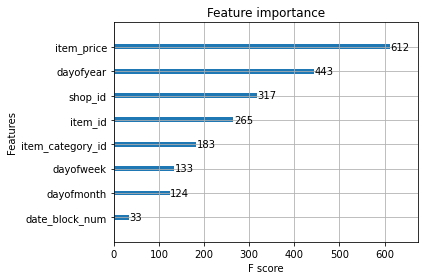

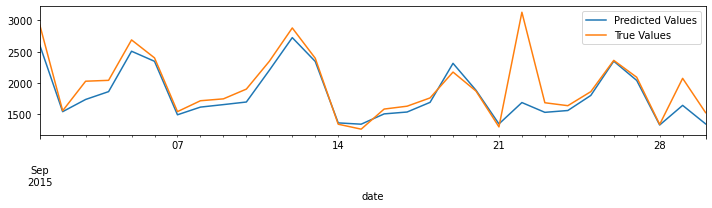

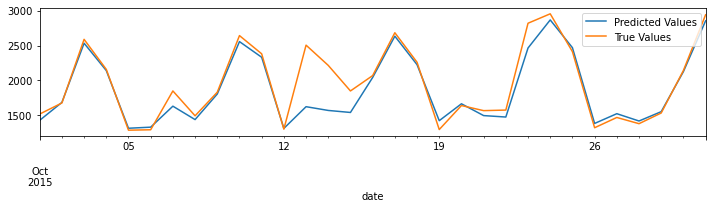

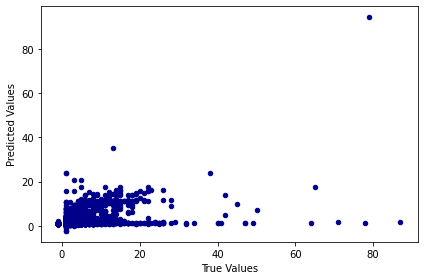

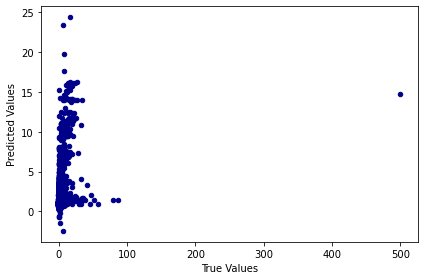

In [24]:
# add in feature engineering, use only most recent year of data
#
# results:
#
# no major difference from using all of the data
# if anything, mse on test worsens using only data from 2015

# feature engineering parameters
# use 2015 data, last month for test, 2nd last month for validation
train_val_test_dates = ['2015-01-01', '2015-09-01', '2015-10-01']
extra_features = True
only_normal_shops = True
only_normal_items = True

num_trees = 39

save_figs='add_features_2015'

summarize_model(num_trees=num_trees,
                train_val_test_dates=train_val_test_dates,
                extra_features=extra_features,
                only_normal_shops=only_normal_shops,
                only_normal_items=only_normal_items,
                save_figs=save_figs)
